#### 1. INTRODUCCIÓN Y MOTIVACIÓN

Barack Obama, Bill Gates, Oprah Winfrey, Babe Ruth y Marie Curie son zurdos... Y según un [estudio de 1991](https://www.nejm.org/doi/full/10.1056/NEJM199104043241418), las personas zurdas mueren en promedio nueve años antes que las personas diestras. ¿Será esto realmente cierto?

En este ejercicio exploraremos dicho fenómeno utilizando datos de distribución de la edad para ver si podemos reproducir una diferencia en la edad promedio de muerte, a partir de las tasas cambiantes de zurdera a lo largo del tiempo, refutando la afirmación de que las personas zurdas mueren temprano. Se utilizarán librerías de Python como Pandas y el teorema de Bayes para analizar la probabilidad de tener cierta edad al morir si se reportó zurdera.

Una encuesta de National Geographic en 1986 obtuvo más de un millón de respuestas que incluían edad, sexo y preferencia manual para escribir y lanzar. Los investigadores Avery Gilbert y Charles Wysocki analizaron estos datos y notaron que las tasas de zurdera eran alrededor del 13% para personas menores de 40 años, pero disminuyeron con la edad a alrededor del 5% a los 80 años. Concluyeron que, basándose en el análisis de un subgrupo de personas que lanzan con la mano izquierda pero escriben con la derecha, esta dependencia de la edad se debía principalmente al cambio en la aceptabilidad social del zurdera. Esto significa que las tasas no son específicamente un factor de la edad, sino del año en que naciste, y si se hiciera el mismo estudio hoy en día, deberíamos esperar una versión desplazada de la misma distribución en función de la edad. En última instancia, veremos qué efecto tiene esta tasa variable en la edad promedio aparente de muerte de las personas zurdas, empezando por visualizar las tasas de zurdera en función de la edad.

En este ejercicio se utilizarán dos datasets: [datos de distribución de muertes](https://www.cdc.gov/nchs/data/statab/vs00199_table310.pdf) para Estados Unidos del año 1999 ([web aquí](https://www.cdc.gov/nchs/nvss/mortality_tables.htm)) y tasas de zurdera digitalizadas de una figura en este [artículo](https://pubmed.ncbi.nlm.nih.gov/1528408/) de 1992 de Gilbert y Wysocki.

In [31]:
# Importamos las librerías necesarias: 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# Cargamos los datos: 

data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
zurdo_data = pd.read_csv(data_url_1)
zurdo_data.head()

,Age,Male,Female
0,10,12.717558,12.198041
1,11,15.318830,11.144804
2,12,14.808281,11.549240
3,13,13.793744,11.276442
4,14,15.156304,11.572906


Text(0, 0.5, 'Tasas de zurdera')

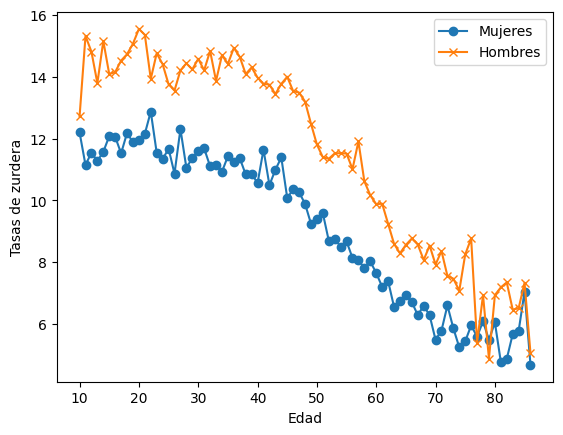

In [50]:
# Gráfica de la Tasa de hombres y mujeres zurdos vs edad

%matplotlib inline
fig, ax = plt.subplots() 

ax.plot("Age", "Female", data=zurdo_data, marker = 'o')
ax.plot("Age", "Male", data=zurdo_data, marker = 'x') 
ax.legend(labels=["Mujeres", "Hombres"])
ax.set_xlabel("Edad")
ax.set_ylabel("Tasas de zurdera")


#### 2. TASAS DE ZURDERA EN EL TIEMPO

A continuación, se proporciona una gráfica de las tasas de zurdera en función del año de nacimiento, haciendo un promedio para obtener una tasa única para ambos sexos. 

Dado que el estudio se realizó en 1986, los datos después de esta conversión serán el porcentaje de personas vivas en 1986 que son zurdas en función del año en que nacieron. 

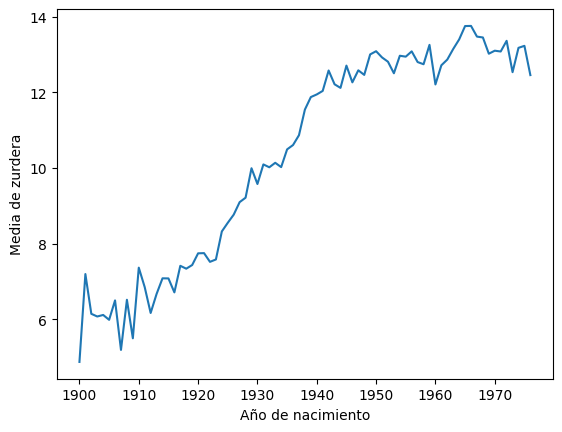

In [34]:
zurdo_data['Birth_year'] = 1986 - zurdo_data['Age']


zurdo_data['Mean_lh'] = (zurdo_data["Male"] + zurdo_data["Female"]) / 2

zurdo_data.plot(x="Birth_year", y="Mean_lh", kind="line")

plt.xlabel("Año de nacimiento")
plt.ylabel("Media de zurdera")

plt.legend().remove()
plt.show()

#### 3. TEOREMA DE BAYES

En primer lugar, se formalizan los eventos de los que se quieren calcular las probabilidades. Notemos que la probabilidad de morir a una cierta edad sabiendo que se es zurdo **no** es igual a la probabilidad de ser zurdo sabiendo la edad a la que se murió. 

- P(A | Z) representa la probabilidad de morir a una cierta edad A si sabemos se es zurdo (Z).
- Análogamente, se representa si se es diestro (D): P(A | D).

El Teorema de Bayes se enuncia tal que:
$$ P(A | Z) = \frac{P(Z | A)\cdot P(A)}{P(Z)} $$

- P(Z | A) es la probabilidad de ser zurdo si se sabe que murió a una cierta edad A.
- P(A) es la probabilidad de morir a una cierta edad.
- P(Z) es la probabilidad de ser zurdo. 

Para calcular P(Z | A) para edades que puedan caer fuera de los datos originales, es necesario extrapolar los datos a años anteriores y posteriores. Dado que las tasas se estabilizan a principios y finales del siglo XX, se utilizarán algunos puntos al final y al principio, y se tomará la media para extrapolar las tasas en cada extremo. El número de puntos utilizados para esto es arbitrario, pero tomaremos 10 ya que los datos parecen estables hasta alrededor de 1910.

In [40]:
def P_Z_dado_A(edades_muerte, año_estudio=1990):
    """ P(Zurdo | edades de muerte), calculado en base a las tasas de zurdera reportadas.
    Inputs: un vector con las edades de muerte, y el año del estudio (1900)
    Output: probabilidad de zurdera sabiendo que los sujetos murieron en `año_estudio` a las edades `edades_muerte` """
    
    # Usar la media de los 10 primeros y 10 últimos puntos para las tasas de zurdera antes y después del inicio
    tasa_principios_1900 = zurdo_data['Mean_lh'][:10].mean()
    tasa_finales_1900 = zurdo_data['Mean_lh'][-10:].mean()
    tasas_medias = zurdo_data.loc[zurdo_data['Birth_year'].isin(año_estudio - edades_muerte)]['Mean_lh']
    edad_mas_joven = año_estudio - 1986 + 10 # la edad más joven es 10
    edad_mas_vieja = año_estudio - 1986 + 86 # la edad más vieja es 86
    
    P_retorno = np.zeros(edades_muerte.shape) # crear un arreglo vacío para almacenar los resultados
    # extraer la tasa de zurdera para las personas de edades 'edades_muerte'
    P_retorno[edades_muerte > edad_mas_vieja] = tasa_finales_1900 / 100
    P_retorno[edades_muerte < edad_mas_joven] = tasa_principios_1900 / 100
    P_retorno[np.logical_and((edades_muerte <= edad_mas_vieja), (edades_muerte >= edad_mas_joven))] = tasas_medias / 100
    
    return P_retorno

#### 4. ¿CUÁNDO ES MÁS PROBABLE EL FALLECIMIENTO?

Para estimar la probabilidad de vivir hasta una edad A se puede usar el número de personas uqe murieron en un año dado y qué edad tenían para sacar la distribución de edades de muerte. Si se normalizan los números con respecto  al número total de personas que murieron, podríamos pensar de estos datos como una distribución de probabilidad que nos da la probabilidad  de morir a una edad A. Los datos que se usarán para este cometido son de EEUU para el año 1999 (lo más actual que se ha podido encontrar para el rango de tiempo trabajado).

A continuación, vamos a cargar los datos de la distribución y visualizarlo. La primera columna es la edad, y las demás columnas son el número de personas que murieron a dicha edad.  

In [36]:
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"
dist_muertes_data = pd.read_csv(data_url_2, sep = '\t',skiprows=[1])

dist_muertes_data.head()

,Age,Both Sexes,Male,Female
0,0,27937.0,15646.0,12291.0
1,1,1989.0,1103.0,886.0
2,2,1376.0,797.0,579.0
3,3,1046.0,601.0,445.0
4,4,838.0,474.0,364.0


Text(0, 0.5, 'Número de muertes')

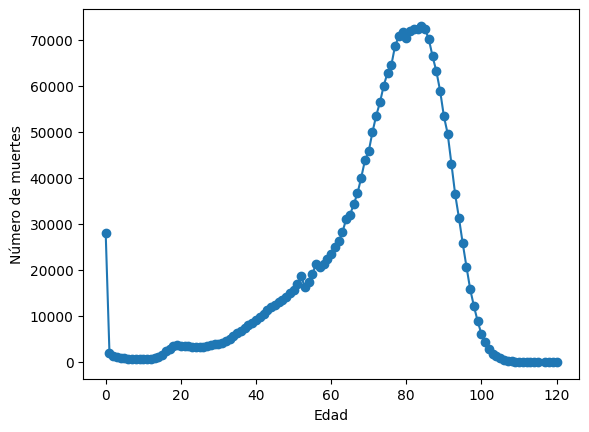

In [45]:
dist_muertes_data = dist_muertes_data.dropna(subset=['Both Sexes']) # quitamos los NaN del campo Both Sexes

fig, ax = plt.subplots()
ax.plot(dist_muertes_data['Age'], dist_muertes_data['Both Sexes'], marker='o')
ax.set_xlabel('Edad')
ax.set_ylabel('Número de muertes')

#### 5. LA PROBABILIDAD TOTAL DE ZURDERA

En el bloque anterior se han cargado los datos para obtener P(A), y ahora se va a calcular P(Z). P(Z) es la probabilidad de que una persona que muere en nuestro año de estudio particular sea zurda, suponiendo que no sabemos nada más sobre ellos. Esto es la media de zurdera en la población de personas fallecidas, calculando la suma de las probabilidades de zurdera para cada edad, con el número de personas fallecidas para cada edad como pesos y luego dividido por el número total de personas fallecidas. Es decir:

$$P(Z) = \frac{\sum_{A}P(Z | A)N(A)}{\sum_{A}N(A)}$$

donde N(A) es el número de personas que fallecieron a la edad A (y que se obtiene de dist_muertes_data).

In [41]:
def P_Z(dist_muertes_data, año_estudio=1990):
    """ Probabilidad total de ser zurdo si se falleció en el año de estudio
Input: dataset de los datos de distribución de muertes, año de estudio
Output: P(Z), un número decimal único """
    p_list = dist_muertes_data['Both Sexes'] * P_Z_dado_A(dist_muertes_data['Age'],año_estudio) 
    p = np.sum(p_list) 
    return p/np.sum(dist_muertes_data['Both Sexes']) 

print(P_Z(dist_muertes_data))

0.07766387615350638
